In [264]:
import os
import tensorflow as tf
import json
import pandas as pd
import numpy as np
import random

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking

In [265]:
# Folders, named after the file label
labels = ["LEFT_ONE", "LEFT_TWO", "LEFT_THREE",
          "RIGHT_ONE", "RIGHT_TWO", "RIGHT_THREE"]

# Store the dataframes
dataframes = []

# Go through each label
for label in labels:
    # Go through each file in folder
    folder_path = os.listdir(label)

    for file_name in folder_path:
        # Read the file
        df = pd.read_parquet(f"{label}/{file_name}")
        df["sign"] = labels.index(label)
        dataframes.append(df)

    print(f"{label} has been processed!")




LEFT_ONE has been processed!
LEFT_TWO has been processed!
LEFT_THREE has been processed!
RIGHT_ONE has been processed!
RIGHT_TWO has been processed!
RIGHT_THREE has been processed!


In [266]:
# Define empty lists to store features and labels
features_list = []
labels_list = []

for dataframe in dataframes:
    # Extract features (all columns except the last one) and labels (last column)
    features = dataframe.iloc[:, :-1].values
    labels = dataframe["sign"].values

    features_list.append(features)
    labels_list.append(labels)

In [267]:
# Step 1: Convert Dataframes to Tensors
feature_tensors = []
label_tensors = []

for df in dataframes:
    # Extract features and labels from the dataframe
    features = df.iloc[:, :-1].values  # Exclude the last column as it's the label
    labels = df['sign'].values
    
    # Convert to NumPy arrays
    features_array = np.array(features)
    labels_array = np.array(labels)
    
    # Convert to TensorFlow tensors
    features_tensor = tf.convert_to_tensor(features_array, dtype=tf.float32)
    labels_tensor = tf.convert_to_tensor(labels_array, dtype=tf.int64)
    
    feature_tensors.append(features_tensor)
    label_tensors.append(labels_tensor)

In [268]:
all_features = tf.concat([feature_tensors], axis=0)
all_labels = tf.concat([label_tensors], axis=0)

In [269]:
from sklearn.model_selection import train_test_split

# Assuming you have your data as TensorFlow tensors
features_train, features_val, labels_train, labels_val = train_test_split(
    all_features.numpy(), all_labels.numpy(), test_size=0.2, random_state=42)

In [273]:
# Step 4: Create an LSTM Model
model = tf.keras.Sequential()
model.add(Masking(mask_value=0, input_shape=(4, 21)))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(6, activation='softmax'))

# Step 5: Compile the Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 6: Train the Model
trained_model = model.fit(features_train, labels_train, epochs=25, validation_data=(features_val, labels_val), batch_size=16)

model.save("hand_model.h5")

Epoch 1/25
741/741 [==============================] - 2s 2ms/step - loss: 1.4636 - accuracy: 0.4348 - val_loss: 1.1735 - val_accuracy: 0.5410
Epoch 2/25
741/741 [==============================] - 1s 1ms/step - loss: 1.0007 - accuracy: 0.6149 - val_loss: 0.8816 - val_accuracy: 0.6172
Epoch 3/25
741/741 [==============================] - 1s 1ms/step - loss: 0.8072 - accuracy: 0.6663 - val_loss: 0.7420 - val_accuracy: 0.6960
Epoch 4/25
741/741 [==============================] - 1s 1ms/step - loss: 0.6960 - accuracy: 0.7163 - val_loss: 0.6407 - val_accuracy: 0.7637
Epoch 5/25
741/741 [==============================] - 1s 1ms/step - loss: 0.6147 - accuracy: 0.7636 - val_loss: 0.5856 - val_accuracy: 0.7966
Epoch 6/25
741/741 [==============================] - 1s 1ms/step - loss: 0.5463 - accuracy: 0.8023 - val_loss: 0.5135 - val_accuracy: 0.8265
Epoch 7/25
741/741 [==============================] - 1s 1ms/step - loss: 0.4903 - accuracy: 0.8313 - val_loss: 0.4605 - val_accuracy: 0.8444
Epoch 

<class 'list'>
<class 'list'>


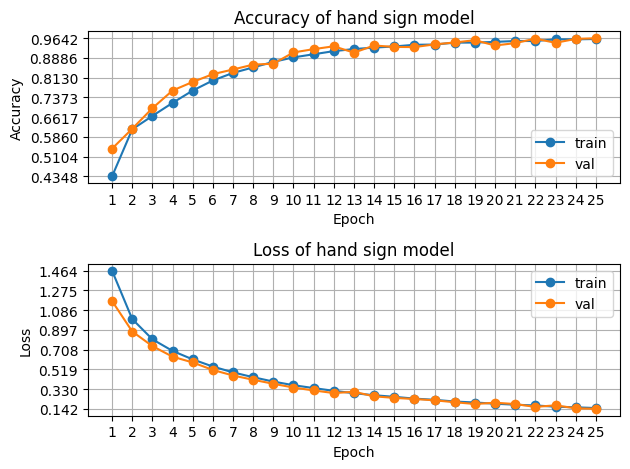

In [288]:
from matplotlib import pyplot as plt


history = trained_model.history
fig, axes = plt.subplots(2)
stats = ["accuracy", "loss"]

for i in range(len(axes)):
    ax = axes[i]
    stat = stats[i]

    # Title
    ax.set_title(f"{stat.capitalize()} of hand sign model")

    # Plotting
    print(type(history[stat]))
    ax.plot(range(1, 1+len(history[stat])), history[stat], "-o")
    ax.plot(range(1, 1+len(history[f"val_{stat}"])), history[f"val_{stat}"], "-o")

    # Labelling the axes + making legends
    ax.set_xlabel("Epoch")
    ax.set_ylabel(f"{stat.capitalize()}")

    start, ending, x_step = 0, 26, 5
    ax.set_xticks([x for x in range(1, len(history[stat]) + 1)])

    low = min(min(history[stat]), min(history[f"val_{stat}"]))
    high = max(max(history[stat]), max(history[f"val_{stat}"]))
    y_step = (high - low) / 7
    ax.set_yticks(np.arange(low, high + y_step, y_step))

    # Legend + grid
    ax.grid()
    legend_postion = "lower right" if stat == "accuracy" else "upper right"
    ax.legend(["train", "val"], loc=legend_postion)

# Reveal the graph
fig.tight_layout()
plt.show()
